In [1]:
import os
import rasterio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [140]:
os.chdir('/my_directory')

map_fp = 'Classified_map.tif'


class_vals = [0,1,2,3] # Classes to sample

sample_size = 30 # Number of samples PER CLASS

In [141]:
m = rasterio.open(map_fp)
d = m.read(1)
d

array([[ 0,  1, 99, ..., 99, 99, 99],
       [ 0,  1,  1, ..., 99, 99, 99],
       [ 0,  1,  1, ..., 99, 99, 99],
       ...,
       [99, 99, 99, ...,  1,  1,  1],
       [99, 99, 99, ...,  3,  3,  1],
       [99, 99, 99, ..., 99, 99, 99]], dtype=uint8)

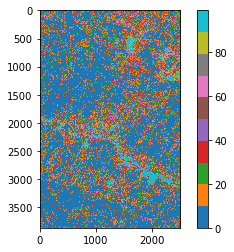

In [142]:
plt.imshow(d, cmap='tab10')
plt.colorbar()
plt.show()

In [143]:
testing_array = np.zeros(d.shape)
treecap_array = np.full(d.shape, 99)
full_df = pd.DataFrame(columns=['x_coord', 'y_coord', 'pred_class'])

In [144]:
# Function to generate random points from an array

def return_rando_index(array, sample_size=30):
    # Get the index value of non-zero numbers
    rand_arr = np.nonzero(array)
    
    # Create a range list for sampling indexed values
    index_array = list(range(0, len(rand_arr[0])))
    
    # Generate a random sample 
    sample_index = np.random.choice(index_array, size=sample_size, replace=False)
    
    # Get the values at the randomly-selected points in the array
    sample_x = rand_arr[0][sample_index]
    sample_y = rand_arr[1][sample_index]
    
    return sample_x, sample_y

In [145]:
# Loop through the class values to create a stratified random sample

for val in class_vals:
    # Select only those points in this class (val)
    array = d == val # returns boolean array
    array = array.astype('int') # converts boolean to 0 and 1 
    
    # Get the random sample
    x_coord, y_coord = return_rando_index(array, sample_size)
    
    # Fill the blind array
    testing_array[x_coord, y_coord] = 1 
    
    #Fill the array with values predicted by the model
    treecap_array[x_coord, y_coord] = val 
    
    # Get the geographic coordinates of the points
    coords = m.xy(x_coord, y_coord) 
    
    # Put coodinates/class into a dataframe
    sample_df = pd.DataFrame(columns=['x_coord', 'y_coord', 'pred_class']) 
    sample_df['x_coord'] = coords[0]
    sample_df['y_coord'] = coords[1]
    sample_df['pred_class'] = val
    
    # Fill in the full dataframe containin all samples
    full_df = pd.concat([full_df, sample_df])   

In [146]:
# Check that values are correct
print(np.unique(testing_array, return_counts=True))
print(np.unique(treecap_array, return_counts=True))

(array([0., 1.]), array([9631460,     120]))
(array([ 0,  1,  2,  3, 99]), array([     30,      30,      30,      30, 9631460]))


In [147]:
full_df

,x_coord,y_coord,pred_class
0,355896.9,3841460.7,0
1,355421.7,3840542.1,0
2,355365.9,3841437.9,0
3,355510.5,3840106.5,0
4,355344.9,3839976.3,0
...,...,...,...
25,356062.5,3840966.9,3
26,355449.9,3840928.5,3
27,356666.7,3842022.3,3
28,356403.3,3841116.9,3


In [148]:
# Create a geodataframe/shapefile using the coordinate values
gdf = gpd.GeoDataFrame(full_df, geometry=gpd.points_from_xy(full_df['x_coord'], full_df['y_coord']))
gdf.set_crs(crs=m.crs, inplace=True)

,x_coord,y_coord,pred_class,geometry
0,355896.9,3841460.7,0,POINT (355896.900 3841460.700)
1,355421.7,3840542.1,0,POINT (355421.700 3840542.100)
2,355365.9,3841437.9,0,POINT (355365.900 3841437.900)
3,355510.5,3840106.5,0,POINT (355510.500 3840106.500)
4,355344.9,3839976.3,0,POINT (355344.900 3839976.300)
...,...,...,...,...
25,356062.5,3840966.9,3,POINT (356062.500 3840966.900)
26,355449.9,3840928.5,3,POINT (355449.900 3840928.500)
27,356666.7,3842022.3,3,POINT (356666.700 3842022.300)
28,356403.3,3841116.9,3,POINT (356403.300 3841116.900)


In [149]:
# Write the shapefile
shp_fp = map_fp[:-4] + '_accuracyPoints.shp'
gdf.to_file(shp_fp)

/home/sarahwegmueller/miniconda3/envs/TreeCAP_v2/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [150]:
# Write a point file with no class data
empty = gpd.GeoDataFrame(geometry=gdf['geometry'])
empty.set_crs(m.crs, inplace=True)

empty_shp_fp = map_fp[:-4] + '_accuracyPoints_noClass.shp'
empty.to_file(empty_shp_fp)

/home/sarahwegmueller/miniconda3/envs/TreeCAP_v2/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [51]:
### IF NEEDED ###

# Write rasters to file
profile = m.profile
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 99.0, 'width': 7234, 'height': 5398, 'count': 1, 'crs': CRS.from_epsg(26916), 'transform': Affine(0.6, 0.0, 402091.8,
       0.0, -0.6, 4830982.800000001), 'tiled': False, 'interleave': 'band'}

In [87]:
# Write raster with predicted values
pred_sample = map_fp[:-4] + '_pred_key.tif'

with rasterio.open(pred_sample, 'w', **profile) as dst:
    dst.write(treecap_array, 1)

In [89]:
# Write raster with predicted values
testing_sample = map_fp[:-4] + '_for_accuracy.tif'

profile['nodata'] = 0

with rasterio.open(testing_sample, 'w', **profile) as dst:
    dst.write(testing_array, 1)